In [1]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

# mis importaciones 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import yaml
import datetime

# Fijar la semilla para reproducibilidad
seed = 42  
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>

# Mis funciones opcionales

Sólo para guardar en un archivo `resultado.yaml` los parámetros de entrada que varían y el dataframe resultado con la pérdida final vs época. 
También se va a almacenar los gráficos en archivos png de la Pérdida vs Época.

**Graficar_Epocas_Perdicas** Grafico la Pérdida vs Época, y guardo la figura. 

**guardar_resultados_yaml** Guarda todos los parámetros, hiperparámetros, accuracy y el dataframe de Pérdida vs Época

**cargar_parametros** Cargará tanto los parámetros como los hiperparámetros donde se elige por código cual set de parámetros e hiperparámetros se usará. 

In [57]:
# Gráfico de la pérdida en el entrenamiento con barras
def Graficar_Epocas_Perdida(df, titulo):
    color_aleatorio = sns.color_palette("husl", 1)[0]
    plt.bar(df['Época'], df['Pérdida'], color=color_aleatorio, alpha=0.7)
    plt.xticks(ticks=range(1, df.shape[0]+1), labels=range(1, df.shape[0]+1))
    plt.grid(alpha=0.3)
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title(titulo)

    # Guardar el gráfico
    if not os.path.exists('graficos'):
        os.makedirs('graficos')
        
    fecha = datetime.datetime.now().strftime("%y-%m-%d_%f")    
    plt.savefig(f'graficos/{fecha}_grafico_{titulo}.png')
    plt.show()
    
#######################################    
# Guardar resultados en un archivo YAML    
def guardar_resultados_yaml(parametros, hiperparametros, df, accuracy, performance, nombre_archivo):
    hr = datetime.datetime.now().strftime("%y-%m-%d_%f")  
    resultados = {
        'timestamp': hr,
        'resultado' : {
            'parametros': parametros,
            'hiperparametros': hiperparametros,
            'df': df.to_dict(orient='records'),
            'accuracy': accuracy, 
            'performance': performance
        }
    }
      
    if not os.path.exists('respuesta'):
        os.makedirs('respuesta')
    ruta_file = f'respuesta/{nombre_archivo}'
    
    # cargar los datos existentes en el archivo YAML
    try:
        with open(ruta_file, 'r') as file:
            old_respuesta = yaml.safe_load(file)
            if old_respuesta is None:
                old_respuesta = []
    except FileNotFoundError:
        old_respuesta = []

    old_respuesta.append(resultados)
    
    with open(ruta_file, 'w') as file:
        yaml.dump(old_respuesta, file, default_flow_style=False, allow_unicode=True)

#######################################
# Cargar parámetros desde un archivo YAML        
def cargar_parametros(nombre_archivo):
    with open(nombre_archivo, 'r') as file:
        parametros_cargados = yaml.safe_load(file)
    
    df_param = pd.DataFrame.from_dict(parametros_cargados)
    
    return df_param

##############################
# Setear los parametros 
def setear_parametros(col_param, df):
    # Filtrar la columna específica
    df_param = df[col_param]
    funcion_str = df_param.loc['activation_fn']
    capas_ocultas = df_param.loc['capas_ocultas']
    
    tam_imagen = 28 * 28  # Tamaño de la imagen (por defecto 28x28)
    tam_clase = 10        # Número de clases de salida
    
    return tam_imagen, capas_ocultas, tam_clase, funcion_str

##############################
# Setear los hiperparametros 
def setear_hiperparametros(col_hiper, df):
    # Filtrar la columna específica
    df_hiper = df[col_hiper]
    batch_size = int(df_hiper.loc['batch_size'])
    learning_rate = float(df_hiper.loc['learning_rate'])
    epochs = int(df_hiper.loc['epochs'])
    optimizer_str = df_hiper.loc['optimizer_str']
    
    return batch_size, learning_rate, epochs, optimizer_str

##############################
# Leer resuladaos de un archivo YAML y ponerlos en un dataframe
def leer_resultados(nombre_archivo):
    with open(nombre_archivo, 'r') as file:
        resultados = yaml.safe_load(file)
    
    df_resultados = pd.DataFrame()
    for i in range(len(resultados)):
        df = pd.DataFrame(resultados[i]['resultado']['df'])
        df['timestamp'] = resultados[i]['timestamp']
        df['accuracy'] = resultados[i]['resultado']['accuracy']
        df['performance'] = resultados[i]['resultado']['performance']
        df['capas_ocultas'] = [resultados[i]['resultado']['parametros']['capas_ocultas']] * len(df)
        df['nro_capas'] = len(resultados[i]['resultado']['parametros']['capas_ocultas'])
        df['activation_fn'] = resultados[i]['resultado']['parametros']['activation_fn']
        df['batch_size'] = resultados[i]['resultado']['hiperparametros']['batch_size']
        df['learning_rate'] = resultados[i]['resultado']['hiperparametros']['learning_rate']
        df['epochs'] = resultados[i]['resultado']['hiperparametros']['epochs']
        df['optimizer_str'] = resultados[i]['resultado']['hiperparametros']['optimizer_str']
        
        
        df_resultados = pd.concat([df_resultados, df], ignore_index=True)
    
    return df_resultados


########################
import textwrap
pd.options.mode.copy_on_write = True 
# Graficar accuracy vs parámetros (con barras de diferentes colores)
def graficar_accuracy_parametros(df, nombre_col):
    plt.figure(figsize=(10, 6))
    etiquetas = [textwrap.fill(str(x), width=20) for x in df[nombre_col]]  # Dividir etiquetas largas
    bars = plt.bar(etiquetas, df['accuracy'], color=plt.cm.tab10.colors, edgecolor='black')

    # Personalizar la gráfica
    plt.title("Accuracy vs Set de Parámetros e Hiperparámetros", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.xlabel("Set Parámetros e Hiperparámetros", fontsize=12)
    plt.xticks(rotation=45, fontsize=8)
    plt.grid(visible=True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Mostrar valores encima de cada barra
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                f'{bar.get_height():.2f}', ha='center', fontsize=8)

    plt.show()
    
#######################    
def escribir_label(x):
    return 'Res:' + str(x)[-6:]

#######################

# Reorganizar y regenerar el dataframe
def reorganizar_dataframe_comprimido(df):
    df_comprimido = df.loc[df.groupby('timestamp')['accuracy'].idxmax()] # Obtener el máximo accuracy por timestamp con idxmax indicando la fila
    df_comprimido = df_comprimido.reset_index(drop=True)
    # genero las columnas de parametros y hiperparametros para el dataframe comprimido
    df_comprimido['parametros'] = (
        "act_fn:" + df_comprimido['activation_fn'].astype(str) + " - " +
        "c:" + df_comprimido['nro_capas'].astype(str)
    )
    df_comprimido['hiperparametros'] = (
        "op_fn:" + df_comprimido['optimizer_str'].astype(str) + " - " +
        "batch:" + df_comprimido['batch_size'].astype(str) + " - " +
        "lr:" + df_comprimido['learning_rate'].astype(str) + " - " +
        "e:" + df_comprimido['epochs'].astype(str)
    )
    # como no me cupo en el gráfico, genero una etiqueta más corta
    df_comprimido['label'] = df_comprimido['timestamp'].apply(lambda x: escribir_label(x))
    
    df_final = df_comprimido[['label', 'accuracy', 'performance','parametros', 'hiperparametros','timestamp']]
    

    return df_final    
    
######################
# Función para calcular el tiempo de performance
def calcular_performance(timestamp_1, timestamp_2):
    return (timestamp_2 - timestamp_1).total_seconds() /60
######################
# Convertir a horas y minutos
def convertir_MM_SS(total_minutos):
    # total_seconds = int(total_seconds
    minutes = int(total_minutos % 60)  # Minutos restantes
    segundos = int((total_minutos % 1) * 60)  # Segundos restantes
    milisegundos = int(((total_minutos % 1) * 60 % 1) * 1000)  # Milisegundos restantes
    res = f"{minutes:02d}:{segundos:02d},{milisegundos:03d}"  # Formato HH:MM:SS,ms
    return res

######################
def graficar_accuracy_vs_performance(df):
    # Datos
    modelos = df['label']
    accuracy = df['accuracy']
    performance = df['performance']

    # Crear la figura y el primer eje Y
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Gráfico de barras para accuracy con Seaborn
    color1 = '#a90dee'  # morado
    sns.barplot(x=modelos, y=accuracy, ax=ax1, color=color1, edgecolor='black')
    ax1.set_ylabel('Accuracy (%)', color=color1, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color1)

    # Mostrar valores encima de las barras de accuracy
    for i, val in enumerate(accuracy):
        ax1.text(i, val + 0.5, f'{val:.2f}', ha='center', fontsize=10, color=color1)

    # Crear el segundo eje Y
    ax2 = ax1.twinx()
    color2 = '#37a3ff'  # azul
    color_l2 = '#002986'  # azul oscuro para los valores x debajo de las barras
    sns.barplot(x=modelos, y=performance, ax=ax2, color=color2, edgecolor='black', alpha=0.7)
    ax2.set_ylabel('Performance (min)', color=color_l2, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color_l2)

    # Mostrar valores por debajo de las barras de performance
    for i, val in enumerate(performance):
        ax2.text(i, val - 0.3, f'{val:.2f}', ha='center', fontsize=10, color=color_l2)

    # Etiquetas y título
    ax1.set_xticks(np.arange(len(modelos)))
    ax1.set_xticklabels(modelos, rotation=45, ha='right', fontsize=10)
    plt.title('Comparación de Accuracy y Performance por Modelo', fontsize=14)
    plt.tight_layout()
    plt.show()
    
def reorganizar_columnas(df, lista_col):
    # Seleccionar las columnas en el orden de la lista
    columnas_reorganizadas = [col for col in lista_col if col in df.columns]
    # Agregar las columnas restantes que no están en la lista
    columnas_resto = [col for col in df.columns if col not in lista_col]
    # Reorganizar las columnas
    return df[columnas_reorganizadas + columnas_resto]
        
        
    

Generar las combinaciones de parametros para la primera parte. 2.	Se genera un archivo “combi_parametros.YAML” donde se pondrán todas las combinaciones posibles de funciones de activación con las listas de cantidad de neuronas. 

list_activation_fn: ReLU, Tanh, Softplus, Sigmoid

list_Cant_neuronas: [784, 512, 256] [784, 512, 256, 128] [784, 392] [784, 392, 128, 64, 32]

In [7]:
list_activation_fn = ['ReLU', 'Tanh', 'Softplus', 'Sigmoid']

list_Cant_neuronas = [[784, 512, 256], [784, 512, 256, 128], [784, 392], [784, 392, 128, 64, 32]]

def generar_combinaciones_parametros(list_activation_fn, list_Cant_neuronas):
    combinaciones = []
    for activation_fn in list_activation_fn:
        for capas_ocultas in list_Cant_neuronas:
            combinaciones.append({'activation_fn': activation_fn, 'capas_ocultas': capas_ocultas})
    return combinaciones

def guardar_combinaciones_yaml(combinaciones, tipo:str, archivo_yaml):
    data = {}
    for i, combinacion in enumerate(combinaciones, start=1):
        key = f'{tipo}_{i}'
        data[key] = combinacion
    with open(archivo_yaml, 'w') as archivo:
        yaml.dump(data, archivo, sort_keys=False)


combinaciones = generar_combinaciones_parametros(list_activation_fn, list_Cant_neuronas)
guardar_combinaciones_yaml(combinaciones, 'parametros', 'combi_parametros.yaml')

In [8]:
df_param = cargar_parametros('combi_parametros.yaml')
df_hiper = cargar_parametros('hiperparametros.yaml')
df_hiper

,hiperparametros_1,hiperparametros_2,hiperparametros_3,hiperparametros_4
batch_size,64,128,32,256
epochs,10,20,25,15
learning_rate,0.001,0.0001,0.01,0.001
optimizer_str,Adam,RMSprop,RMSprop,RMSprop


<div style="height: 5px; background: linear-gradient(to right, cyan, lime); margin-bottom: 20px;"></div>

# Mi Clase dínamica de MLP_D

In [26]:

class MLP_D(nn.Module):
    def __init__(self, tam_imagen, capas_ocultas, tam_clase, activation_fn=nn.ReLU, dropout_prob=0.2):
        super(MLP_D, self).__init__()
        
        # se crean las capas desde las listas capas_ocultas y tam_clase, y se guardan en self.capas (nn.ModuleList)
        self.capas = nn.ModuleList()
        # primera capa
        self.capas.append(nn.Linear(tam_imagen, capas_ocultas[0]))
        # capas ocultas
        for i in range(1, len(capas_ocultas)):
            self.capas.append(nn.Linear(capas_ocultas[i-1], capas_ocultas[i]))
        # ultima capa
        self.capas.append(nn.Linear(capas_ocultas[-1], tam_clase))
        
        # Instanciar la función de activación pasada por parámetro
        self.activation_fn = activation_fn() 
        # se guarda la probabilidad de dropout        
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Aplanar la imagen a 1D
        x = x.view(x.size(0), -1)  
        
        # Pasar por las capas ocultas con activación y dropout
        for capa in self.capas[:-1]:  # Todas menos la última capa
            x = self.activation_fn(capa(x))  # Usar la función de activación
            x = self.dropout(x)
        
        # Pasar por la última capa (sin activación ni dropout)
        x = self.capas[-1](x)           
        return x

## Entreno la parte dinámica de la Clase MLP_D

Tuve que fijar la semilla aleatoria en todas las librerías relevantes. Esto incluye PyTorch, NumPy, y Python. Porque al graficar me salían valores diferentes con los mismos valores. 

Generó un archivo `combi_parametros.YAML` los parámetros a cambiar. Luego los muestro en un dataframe. Como guarde el nombre de la función de activación de la misma manera como se llama en la clase de nn.XXX y luego puedo hacer el `getattr(nn, funcion_str)`

Lo mismo por el archivo `hiperparametros.yamml`.

Se crea la función `setear_parametros(col_param, parametro_file)` y `setear_hiperparametros(col_hiper, hiper_file` donde se tiene como entrada el nombre del conjunto de parámetros (o hiperparámetros) que se ha elegido, más el archivo donde están estos datos. Como salida retorna estos parámetros (o hiperparámetros) en tupls de N elementos. 

setear_parametros(col_param, parametro_file) -> activacion_fn, tam_imagen, capas_ocultas, tam_clase, funcion_str

setear_hiperparametros(col_hiper, hiper_file) -> batch_size, learning_rate, epochs, optimizer_fn, optimizer_str

Diferentes funciones de optimización pueden ser:  Adam, SGD, RMSprop, Adagrad, Adadelta, AdamW, ASGD

Diferentes funciones de activación pueden ser: Tanh, Softplus, Sigmoid, GELU, Softmax

In [35]:

# lo dejo en una función para poder reutilizarlo dentro de un bucle con mis parámetros e hiperparámetros
def procesar_MNIST(col_param, col_hiper, df_param, df_hiper, train_dataset, test_dataset, resultados_file, graficar=False):
    # Setear los valores de los parámetros e hiperparámetros para este modelo tienen como parámetro la función de activación y la función de optimización
    tam_imagen, capas_ocultas, tam_clase, funcion_str = setear_parametros(col_param, df_param)
    activation_fn = getattr(nn, funcion_str)

    batch_size, learning_rate, epochs, optimizer_str = setear_hiperparametros(col_hiper, df_hiper)
    optimizer_fn = getattr(optim, optimizer_str)

    # estos son los parametros que se van a usar, los guardo en dictionarios para guardarlos en el archivo YAML
    parametros = {
        'capas_ocultas': capas_ocultas,
        'activation_fn': funcion_str,
        }
    hiperparametros = {
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'optimizer_str': optimizer_str
        }

    # timestamp inicial para la performance  
    timestamp_1 = datetime.datetime.now()
    print(f'Comienza a procesar el modelo en: {timestamp_1}')
    
    train_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True)  # Dataloader para entrenamiento
    test_loader = DataLoader(
        dataset=test_dataset, batch_size=batch_size, shuffle=False)  # Dataloader para prueba

    # Definimos el modelo, la función de pérdida y el optimizador
    modelo = MLP_D(tam_imagen, capas_ocultas, tam_clase, activation_fn)  # Creamos una instancia del modelo MLP_D
    criterion = nn.CrossEntropyLoss()         # Función de pérdida para clasificación
    # Optimizador Adam, SGD, RMSprop, Adagrad, Adadelta, AdamW, ASGD
    optimizer = optimizer_fn(modelo.parameters(), lr=learning_rate)


    epocas = {}
    # Bucle de entrenamiento
    for epoch in range(epochs):
        modelo.train()  # Ponemos el modelo en modo entrenamiento
        for images, labels in train_loader:  # Iteramos sobre lotes de datos
            optimizer.zero_grad()            # Reiniciamos los gradientes
            outputs = modelo(images)          # Hacemos una predicción con el modelo
            loss = criterion(outputs, labels)  # Calculamos la pérdida
            loss.backward()                  # Propagamos los gradientes
            optimizer.step()                 # Actualizamos los pesos del modelo

        # Mostramos la pérdida al final de cada época
        # print(f"Época [{epoch+1}/{epochs}], Pérdida: {loss.item():.4f}")
        epocas[epoch+1] = round(loss.item(), 4)
        
    # timestamp final para la performance    
    timestamp_2 = datetime.datetime.now()
    
    print(f'Termina el procesamiento del modelo a: {timestamp_2}')
    
    # lo pongo en un data frame
    df = pd.DataFrame(epocas.items(), columns=['Época', 'Pérdida'])
    
    if graficar:
        Graficar_Epocas_Perdida(df, "Pérdidas vs Épocas")   
    
    # Evaluación del modelo
    modelo.eval()  # Ponemos el modelo en modo evaluación (desactiva Dropout)
    correct = 0
    total = 0
    with torch.no_grad():  # Desactivamos el cálculo de gradientes para evaluación
        for images, labels in test_loader:  # Iteramos sobre los datos de prueba
            outputs = modelo(images)         # Hacemos predicciones
            _, predicted = torch.max(outputs.data, 1)  # Obtenemos la clase con mayor probabilidad
            total += labels.size(0)         # Total de muestras evaluadas
            correct += (predicted == labels).sum().item()  # Contamos las predicciones correctas

    # Calculamos y mostramos la precisión del modelo
    accuracy = 100 * correct / total
    print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}%")
    
    # Texto para validar donde va el procesamiento
    texto = f'optimazador: {optimizer_str}, batch_size: {batch_size}, learning_rate: {learning_rate}, epochs: {epochs}'
    
    performance = calcular_performance(timestamp_1, timestamp_2)
    print(f'Performance: {performance:.2f} minutos de estos hiperparámetros: {texto}')
    
    # Guardar resultados en un archivo YAML junto con sus parámetros e hiperparámetros
    guardar_resultados_yaml(parametros, hiperparametros, df, accuracy, performance, resultados_file)
    


# Procesa el modelo con los diferenctes parámetros

Se deja los hiperparámetros fijos: 
batch_size	64

epochs	10

learning_rate	0.001	

optimizer_str	Adam	


Procesado modelo 1 de 16 de la combinación de parámetros ReLU - [784, 512, 256]
Comienza a procesar el modelo en: 2024-12-20 15:33:29.065610
Termina el procesamiento del modelo a: 2024-12-20 15:36:10.706168


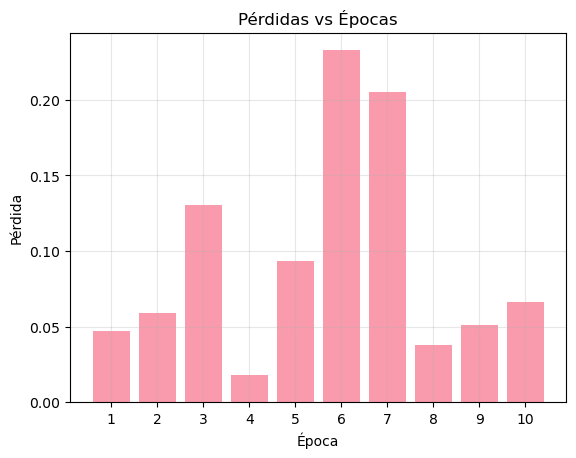

Accuracy en el conjunto de prueba: 97.57%
Performance: 2.69 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10
Procesado modelo 2 de 16 de la combinación de parámetros ReLU - [784, 512, 256, 128]
Comienza a procesar el modelo en: 2024-12-20 15:36:13.078244
Termina el procesamiento del modelo a: 2024-12-20 15:38:53.736987


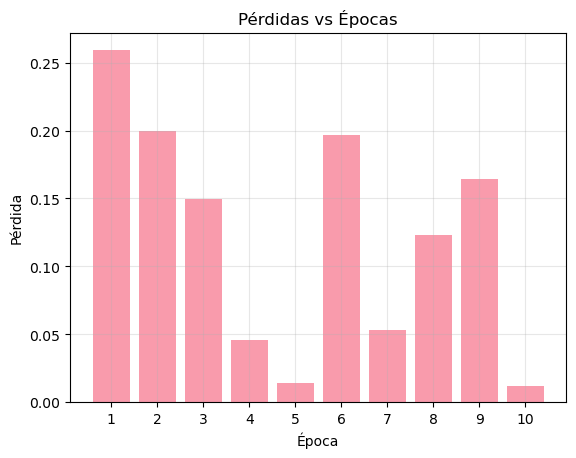

Accuracy en el conjunto de prueba: 97.28%
Performance: 2.68 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10
Procesado modelo 3 de 16 de la combinación de parámetros ReLU - [784, 392]
Comienza a procesar el modelo en: 2024-12-20 15:38:55.994874
Termina el procesamiento del modelo a: 2024-12-20 15:41:28.385509


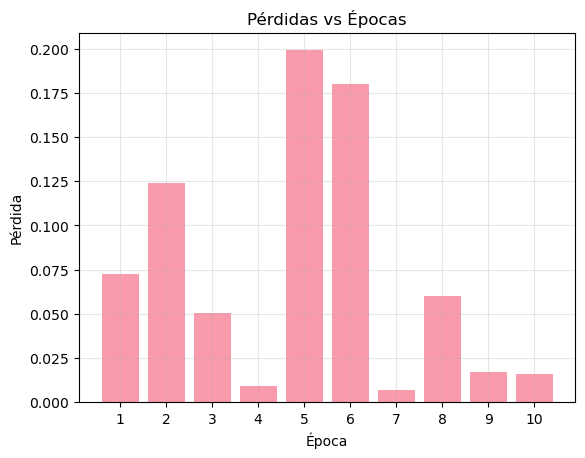

Accuracy en el conjunto de prueba: 97.81%
Performance: 2.54 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10
Procesado modelo 4 de 16 de la combinación de parámetros ReLU - [784, 392, 128, 64, 32]
Comienza a procesar el modelo en: 2024-12-20 15:41:30.640718
Termina el procesamiento del modelo a: 2024-12-20 15:44:12.638176


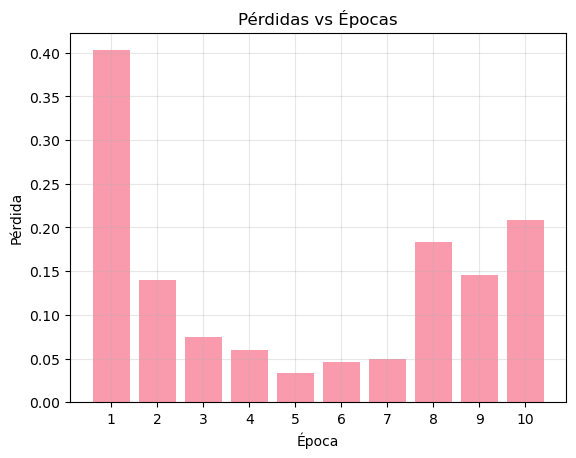

Accuracy en el conjunto de prueba: 97.47%
Performance: 2.70 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10
Procesado modelo 5 de 16 de la combinación de parámetros Tanh - [784, 512, 256]
Comienza a procesar el modelo en: 2024-12-20 15:44:14.923108
Termina el procesamiento del modelo a: 2024-12-20 15:46:49.281669


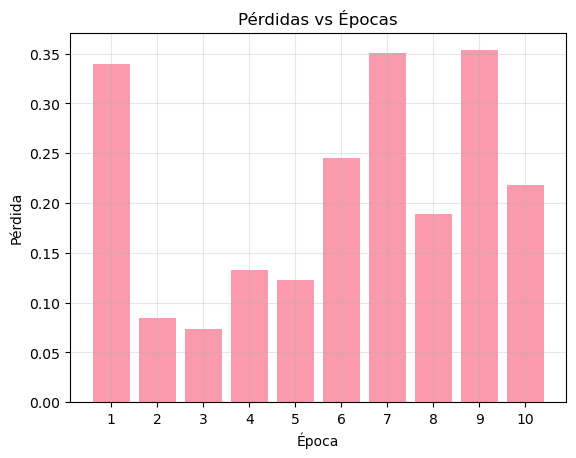

Accuracy en el conjunto de prueba: 96.17%
Performance: 2.57 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10
Procesado modelo 6 de 16 de la combinación de parámetros Tanh - [784, 512, 256, 128]
Comienza a procesar el modelo en: 2024-12-20 15:46:51.350701
Termina el procesamiento del modelo a: 2024-12-20 15:49:32.524727


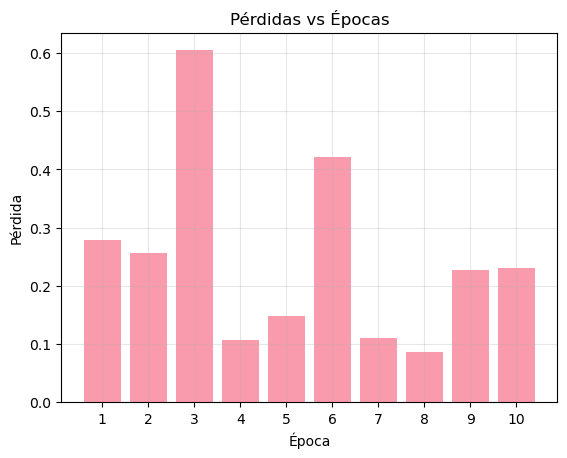

Accuracy en el conjunto de prueba: 95.86%
Performance: 2.69 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10
Procesado modelo 7 de 16 de la combinación de parámetros Tanh - [784, 392]
Comienza a procesar el modelo en: 2024-12-20 15:49:34.554608
Termina el procesamiento del modelo a: 2024-12-20 15:51:56.035939


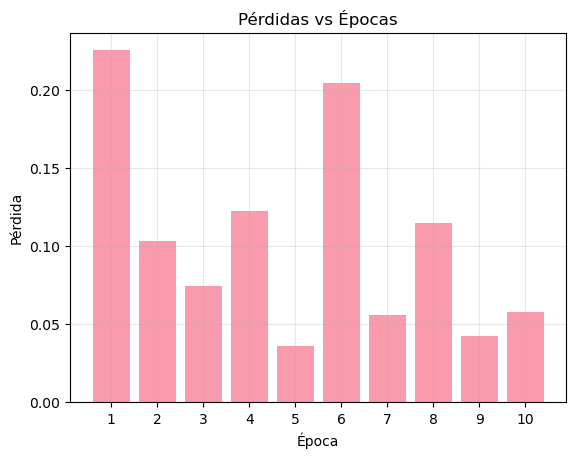

Accuracy en el conjunto de prueba: 96.71%
Performance: 2.36 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10
Procesado modelo 8 de 16 de la combinación de parámetros Tanh - [784, 392, 128, 64, 32]
Comienza a procesar el modelo en: 2024-12-20 15:51:58.017744
Termina el procesamiento del modelo a: 2024-12-20 15:54:27.344216


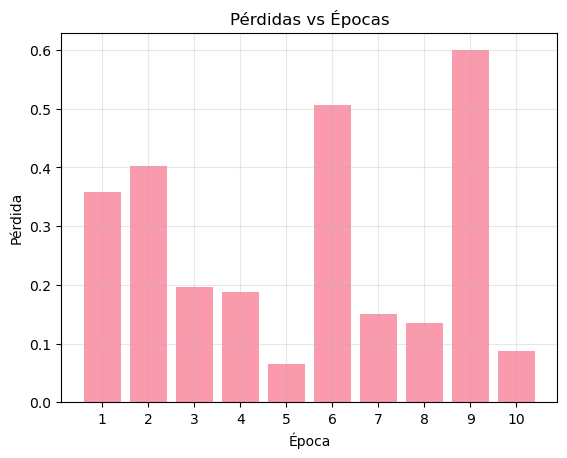

Accuracy en el conjunto de prueba: 95.29%
Performance: 2.49 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10
Procesado modelo 9 de 16 de la combinación de parámetros Softplus - [784, 512, 256]
Comienza a procesar el modelo en: 2024-12-20 15:54:29.401364
Termina el procesamiento del modelo a: 2024-12-20 15:57:12.568867


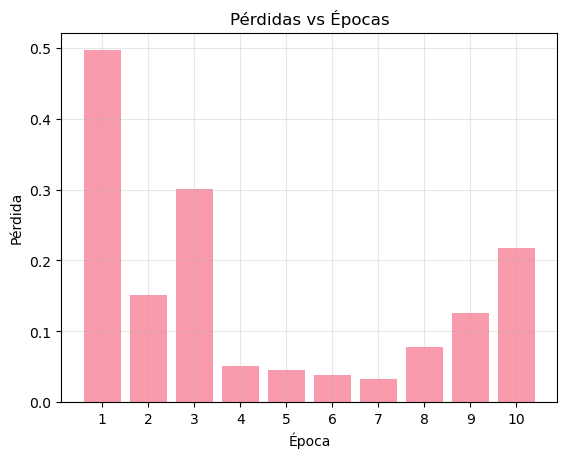

Accuracy en el conjunto de prueba: 97.70%
Performance: 2.72 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10
Procesado modelo 10 de 16 de la combinación de parámetros Softplus - [784, 512, 256, 128]
Comienza a procesar el modelo en: 2024-12-20 15:57:14.946974
Termina el procesamiento del modelo a: 2024-12-20 16:00:00.395475


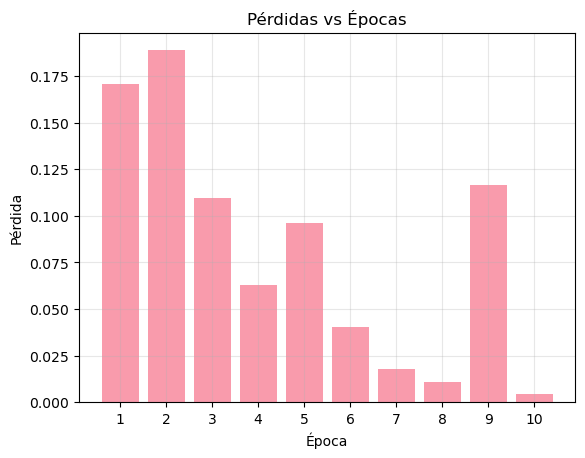

Accuracy en el conjunto de prueba: 97.97%
Performance: 2.76 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10
Procesado modelo 11 de 16 de la combinación de parámetros Softplus - [784, 392]
Comienza a procesar el modelo en: 2024-12-20 16:00:02.763812
Termina el procesamiento del modelo a: 2024-12-20 16:02:25.877256


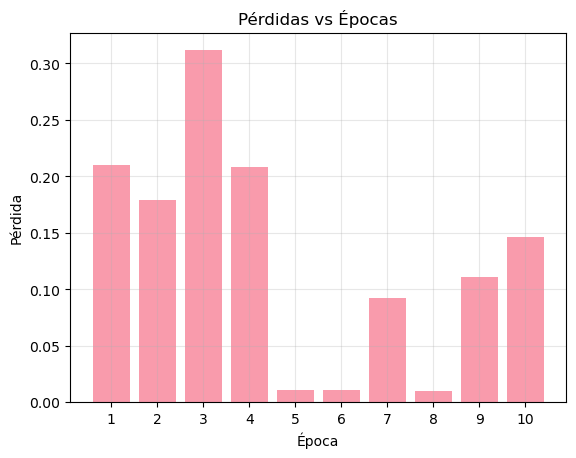

Accuracy en el conjunto de prueba: 97.83%
Performance: 2.39 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10
Procesado modelo 12 de 16 de la combinación de parámetros Softplus - [784, 392, 128, 64, 32]
Comienza a procesar el modelo en: 2024-12-20 16:02:28.167616
Termina el procesamiento del modelo a: 2024-12-20 16:04:57.651092


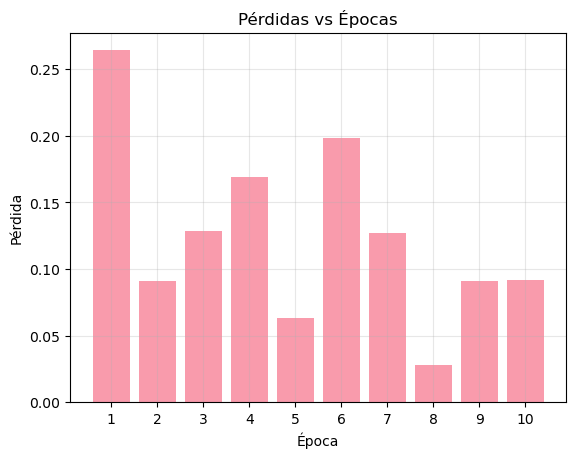

Accuracy en el conjunto de prueba: 97.93%
Performance: 2.49 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10
Procesado modelo 13 de 16 de la combinación de parámetros Sigmoid - [784, 512, 256]
Comienza a procesar el modelo en: 2024-12-20 16:04:59.769416
Termina el procesamiento del modelo a: 2024-12-20 16:07:32.435493


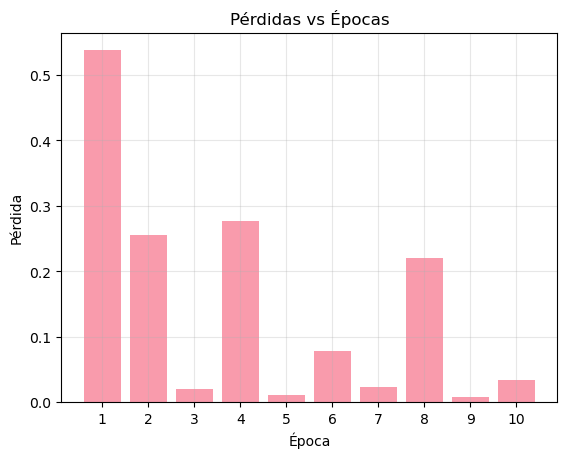

Accuracy en el conjunto de prueba: 97.58%
Performance: 2.54 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10
Procesado modelo 14 de 16 de la combinación de parámetros Sigmoid - [784, 512, 256, 128]
Comienza a procesar el modelo en: 2024-12-20 16:07:34.718792
Termina el procesamiento del modelo a: 2024-12-20 16:10:19.671850


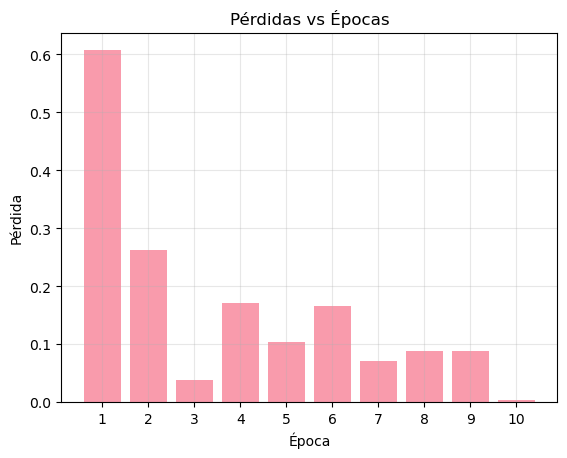

Accuracy en el conjunto de prueba: 97.55%
Performance: 2.75 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10
Procesado modelo 15 de 16 de la combinación de parámetros Sigmoid - [784, 392]
Comienza a procesar el modelo en: 2024-12-20 16:10:21.908661
Termina el procesamiento del modelo a: 2024-12-20 16:12:42.450413


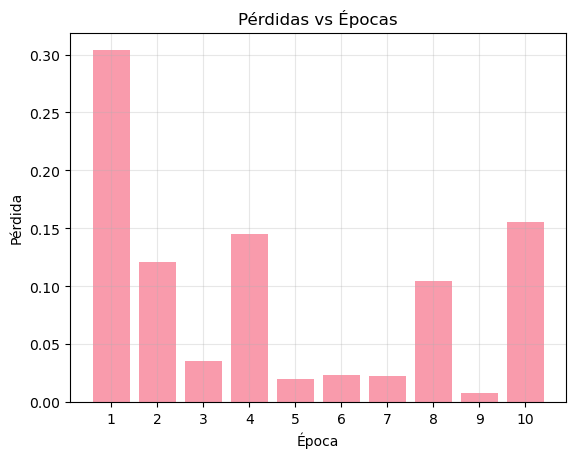

Accuracy en el conjunto de prueba: 97.74%
Performance: 2.34 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10
Procesado modelo 16 de 16 de la combinación de parámetros Sigmoid - [784, 392, 128, 64, 32]
Comienza a procesar el modelo en: 2024-12-20 16:12:44.689896
Termina el procesamiento del modelo a: 2024-12-20 16:15:12.005039


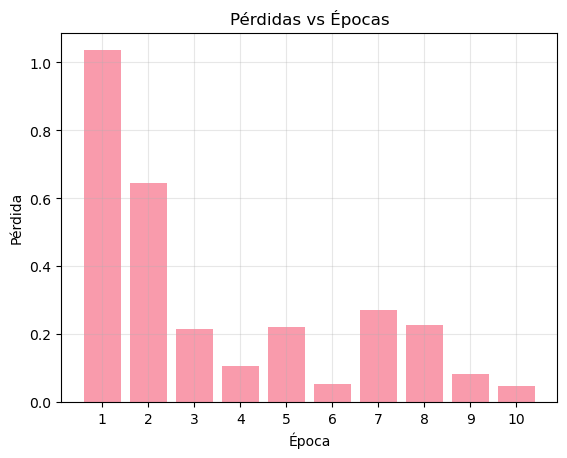

Accuracy en el conjunto de prueba: 96.96%
Performance: 2.46 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 64, learning_rate: 0.001, epochs: 10


In [65]:
######### AQUI SE DEBE EJECUTAR EL CÓDIGO PARA PROCESAR LOS MODELOS CON LOS PARÁMETROS #########
# obtener desde los archiovs los parametros e hiperparametros
df_param = cargar_parametros('combi_parametros.yaml')
df_hiper = cargar_parametros('hiperparametros.yaml')

# Verificar si hay una GPU disponible, de lo contrario usar la CPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocesamiento y carga de datos de MNIST
# esto lo puse fuera del ciclo for, para optimizar el tiempo de ejecución :)
transform = transforms.Compose([
    transforms.ToTensor(),                 # Convertimos imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizamos a media 0 y varianza 1
])
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)  # Dataset de entrenamiento
test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transform, download=True)  # Dataset de prueba

resultados_file = 'resultados.yaml'
    
# procesar los modelos dejando fijo el hiperparametro 1
for i in range(df_param.shape[1]):
    
    col_param = f'parametros_{i+1}'
    col_hiper = 'hiperparametros_1'
    titulo = df_param[col_param].loc['activation_fn'] + ' - ' + str(df_param[col_param].loc['capas_ocultas'])
    print(f"Procesado modelo {i+1} de {df_param.shape[1]} de la combinación de parámetros {titulo}")
    procesar_MNIST(col_param, col_hiper, df_param, df_hiper, train_dataset, test_dataset, resultados_file, graficar=True)
        

# Rescatar los resultados para Analizarlos

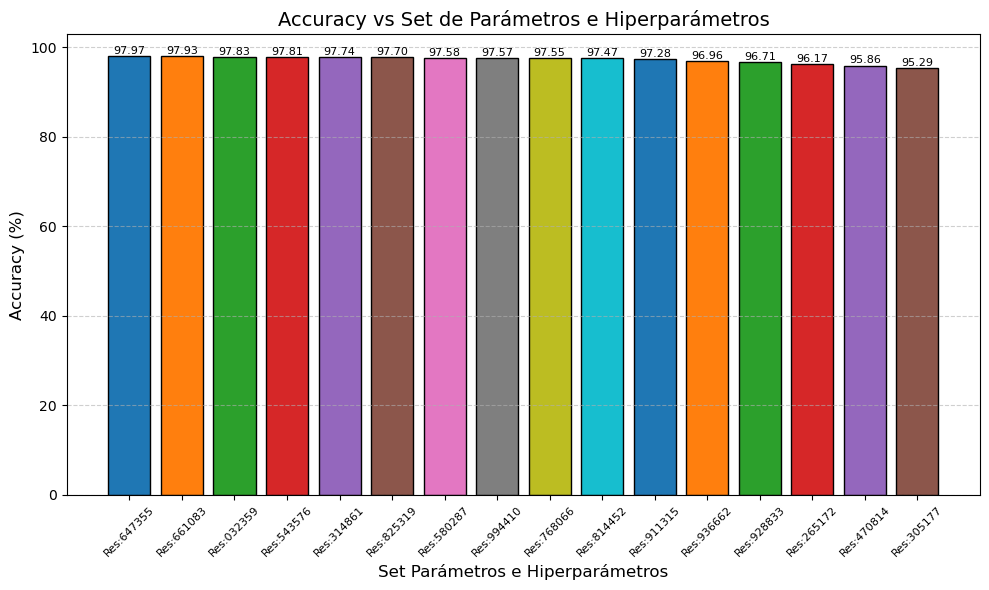

El mejor modelo es el set de Res:647355 con los parámetros  act_fn:Softplus - c:4 
con un accuracy de 97.97% y Performance de 02:45,448 minutos, 
con los hiperparámetros op_fn:Adam - batch:64 - lr:0.001 - e:10


,label,accuracy,performance,parametros,hiperparametros,timestamp,performance_min
7,Res:647355,97.97,2.757475,act_fn:Softplus - c:4,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-20_647355,"02:45,448"
8,Res:661083,97.93,2.491391,act_fn:Softplus - c:5,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-20_661083,"02:29,483"
0,Res:032359,97.83,2.385224,act_fn:Softplus - c:2,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-20_032359,"02:23,113"
5,Res:543576,97.81,2.539844,act_fn:ReLU - c:2,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-20_543576,"02:32,390"
3,Res:314861,97.74,2.342363,act_fn:Sigmoid - c:2,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-20_314861,"02:20,541"
11,Res:825319,97.70,2.719458,act_fn:Softplus - c:3,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-20_825319,"02:43,167"
6,Res:580287,97.58,2.544435,act_fn:Sigmoid - c:3,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-20_580287,"02:32,666"
15,Res:994410,97.57,2.694009,act_fn:ReLU - c:3,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-20_994410,"02:41,640"
9,Res:768066,97.55,2.749218,act_fn:Sigmoid - c:4,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-20_768066,"02:44,953"
10,Res:814452,97.47,2.699958,act_fn:ReLU - c:5,op_fn:Adam - batch:64 - lr:0.001 - e:10,24-12-20_814452,"02:41,997"


In [68]:
# rescatar resultados de un archivo YAML y ponerlos en un dataframe
df_resultados = leer_resultados('respuesta/resultados.yaml')

#reorganizar y regenerar el dataframe, de forma de tener un solo registro por timestamp en el maximo accuracy
df_final = reorganizar_dataframe_comprimido(df_resultados)
df_final['performance_min'] = df_final['performance'].apply(convertir_MM_SS)
df_final = df_final.sort_values(by='accuracy', ascending=False)
graficar_accuracy_parametros(df_final, 'label')
max_index_accuracy = df_final['accuracy'].idxmax()
respuesta_final = f'El mejor modelo es el set de {df_final.loc[max_index_accuracy, "label"]} con los parámetros  {df_final.loc[max_index_accuracy, "parametros"]} \n' +f'con un accuracy de {df_final.loc[max_index_accuracy, "accuracy"]:.2f}% y Performance de {df_final.loc[max_index_accuracy, "performance_min"]} minutos, \n' +f'con los hiperparámetros {df_final.loc[max_index_accuracy, "hiperparametros"]}'
print(respuesta_final)
# exportar el dataframe a un archivo csv, saque la performance porque lo tengo en minutos y segundos, y las ordené a mi gusto
df_exportar = df_final.drop(columns=['performance'])
df_exportar = reorganizar_columnas(df_exportar, ['label', 'accuracy', 'performance_min', 'parametros', 'hiperparametros'])
exportar = df_exportar.to_csv('respuesta/df_final.csv', sep=';', index=False)
df_final



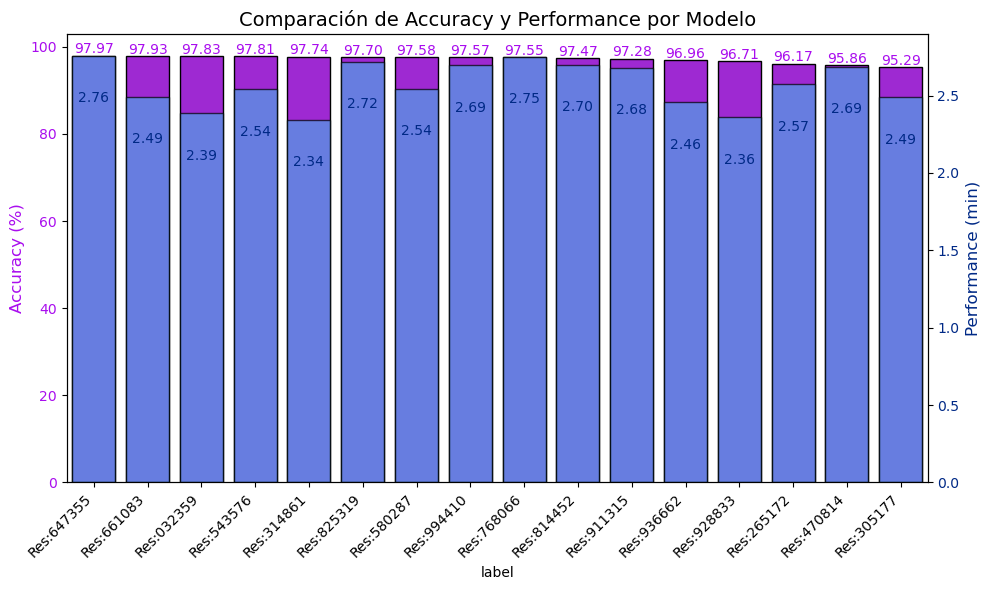

In [69]:
graficar_accuracy_vs_performance(df_final)

## Generar combinaciones de hiperparámetros

funcion_optimizacion = Adam, SGD

learning_rate = 0.1,  0.001

batch_size = 16, 32

epocas = 5, 10

In [72]:
def generar_combi_hiper():
    lista_batch_size = [16, 32]
    lista_learning_rate = [0.01, 0.001 ]
    lista_epochs = [15, 10]
    lista_optimizer_str = ['Adam', 'SGD']
    
    combinaciones = []
    for batch_size in lista_batch_size:
        for learning_rate in lista_learning_rate:
            for epochs in lista_epochs:
                for optimizer_str in lista_optimizer_str:
                    combinaciones.append({'batch_size': batch_size, 'learning_rate': learning_rate, 'epochs': epochs, 'optimizer_str': optimizer_str})
    return combinaciones

combinaciones = generar_combi_hiper()
guardar_combinaciones_yaml(combinaciones,'hiperparametros', 'combi_hiper.yaml')

In [71]:
df_combi_hiper = cargar_parametros('combi_hiper.yaml')
df_combi_hiper

,hiperparametros_1,hiperparametros_2,hiperparametros_3,hiperparametros_4,hiperparametros_5,hiperparametros_6,hiperparametros_7,hiperparametros_8,hiperparametros_9,hiperparametros_10,hiperparametros_11,hiperparametros_12,hiperparametros_13,hiperparametros_14,hiperparametros_15,hiperparametros_16
batch_size,16,16,16,16,16,16,16,16,32,32,32,32,32,32,32,32
learning_rate,0.1,0.1,0.1,0.1,0.001,0.001,0.001,0.001,0.1,0.1,0.1,0.1,0.001,0.001,0.001,0.001
epochs,5,5,10,10,5,5,10,10,5,5,10,10,5,5,10,10
optimizer_str,Adam,SGD,Adam,SGD,Adam,SGD,Adam,SGD,Adam,SGD,Adam,SGD,Adam,SGD,Adam,SGD


In [73]:
# obtener el mejor paramétro obtenido 
# función activación: Softplus - capas:34 – 784, 512, 256, 128]
df_param_best = pd.DataFrame(columns=['activation_fn', 'capas_ocultas'])
df_param_best.loc[0] = ['Softplus', [784, 512, 256, 128] ]
df_param_best = df_param_best.T
df_param_best.columns = ['parametros_1']
df_param_best

,parametros_1
activation_fn,Softplus
capas_ocultas,"[784, 512, 256, 128]"


In [74]:
######### AQUI SE DEBE EJECUTAR EL CÓDIGO PARA PROCESAR LOS MODELOS CON LOS HIPERPARÁMETROS #########
df_hiper = cargar_parametros('combi_hiper.yaml')

# Preprocesamiento y carga de datos de MNIST
# esto lo puse fuera del ciclo for, para optimizar el tiempo de ejecución :)
transform = transforms.Compose([
    transforms.ToTensor(),                 # Convertimos imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizamos a media 0 y varianza 1
])
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)  # Dataset de entrenamiento
test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transform, download=True)  # Dataset de prueba

resultados_hiper_file = 'resultados_hiper.yaml'

# procesar los modelos dejando fijo el hiperparametro 1
for i in range(df_hiper.shape[1]):

    col_param = 'parametros_1' 
    col_hiper = f'hiperparametros_{i+1}'

    titulo = df_hiper[col_hiper].loc['optimizer_str'] + ' - ' + str(df_hiper[col_hiper].loc['epochs']) + ' - ' + str(df_hiper[col_hiper].loc['learning_rate']) + ' - ' + str(df_hiper[col_hiper].loc['batch_size'])

    print(f"Procesado modelo {i+1} de {df_hiper.shape[1]} de la combinación de hiperparámetros {titulo}")
    procesar_MNIST(col_param, col_hiper, df_param_best, df_hiper, train_dataset, test_dataset, resultados_hiper_file)


Procesado modelo 1 de 16 de la combinación de hiperparámetros Adam - 15 - 0.01 - 16
Comienza a procesar el modelo en: 2024-12-20 17:12:31.683459
Termina el procesamiento del modelo a: 2024-12-20 17:20:03.020812
Accuracy en el conjunto de prueba: 10.28%
Performance: 7.52 minutos de estos hiperparámetros: optimazador: Adam, batch_size: 16, learning_rate: 0.01, epochs: 15
Procesado modelo 2 de 16 de la combinación de hiperparámetros SGD - 15 - 0.01 - 16
Comienza a procesar el modelo en: 2024-12-20 17:20:05.279529
Termina el procesamiento del modelo a: 2024-12-20 17:24:58.774888
Accuracy en el conjunto de prueba: 95.22%
Performance: 4.89 minutos de estos hiperparámetros: optimazador: SGD, batch_size: 16, learning_rate: 0.01, epochs: 15
Procesado modelo 3 de 16 de la combinación de hiperparámetros Adam - 10 - 0.01 - 16
Comienza a procesar el modelo en: 2024-12-20 17:25:00.894204
Termina el procesamiento del modelo a: 2024-12-20 17:29:51.641394
Accuracy en el conjunto de prueba: 11.35%
Perfo

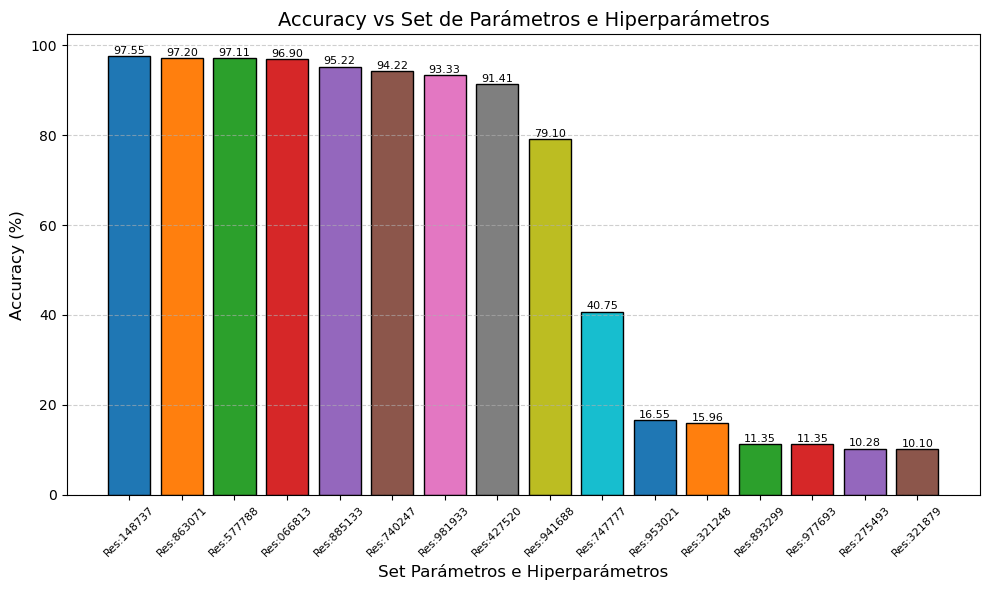

El mejor modelo es el set de Res:148737 con los parámetros  act_fn:Softplus - c:4 
con un accuracy de 97.55% y Performance de 06:02,459 minutos, 
con los hiperparámetros op_fn:Adam - batch:32 - lr:0.001 - e:15


,label,accuracy,performance,parametros,hiperparametros,timestamp,performance_min
1,Res:148737,97.55,6.040992,act_fn:Softplus - c:4,op_fn:Adam - batch:32 - lr:0.001 - e:15,24-12-20_148737,"06:02,459"
9,Res:863071,97.20,4.959643,act_fn:Softplus - c:4,op_fn:Adam - batch:16 - lr:0.001 - e:10,24-12-20_863071,"04:57,578"
6,Res:577788,97.11,3.393026,act_fn:Softplus - c:4,op_fn:Adam - batch:32 - lr:0.001 - e:10,24-12-20_577788,"03:23,581"
0,Res:066813,96.90,7.518879,act_fn:Softplus - c:4,op_fn:Adam - batch:16 - lr:0.001 - e:15,24-12-20_066813,"07:31,132"
10,Res:885133,95.22,4.891589,act_fn:Softplus - c:4,op_fn:SGD - batch:16 - lr:0.01 - e:15,24-12-20_885133,"04:53,495"
7,Res:740247,94.22,3.625667,act_fn:Softplus - c:4,op_fn:SGD - batch:16 - lr:0.01 - e:10,24-12-20_740247,"03:37,540"
15,Res:981933,93.33,4.093608,act_fn:Softplus - c:4,op_fn:SGD - batch:32 - lr:0.01 - e:15,24-12-20_981933,"04:05,616"
5,Res:427520,91.41,2.676438,act_fn:Softplus - c:4,op_fn:SGD - batch:32 - lr:0.01 - e:10,24-12-20_427520,"02:40,586"
12,Res:941688,79.10,4.996444,act_fn:Softplus - c:4,op_fn:SGD - batch:16 - lr:0.001 - e:15,24-12-20_941688,"04:59,786"
8,Res:747777,40.75,3.508727,act_fn:Softplus - c:4,op_fn:SGD - batch:16 - lr:0.001 - e:10,24-12-20_747777,"03:30,523"


In [75]:
# rescatar resultados de un archivo YAML y ponerlos en un dataframe
df_resultados = leer_resultados('respuesta/resultados_hiper.yaml')

#reorganizar y regenerar el dataframe, de forma de tener un solo registro por timestamp en el maximo accuracy
df_final_hiper = reorganizar_dataframe_comprimido(df_resultados)
df_final_hiper['performance_min'] = df_final_hiper['performance'].apply(convertir_MM_SS) # formato minutos y segundos

df_final_hiper = df_final_hiper.sort_values(by='accuracy', ascending=False)

graficar_accuracy_parametros(df_final_hiper, 'label')

max_index_accuracy = df_final_hiper['accuracy'].idxmax()

# obtener el mejor modelo con los hiperparámetros
respuesta_final_hiper = f'El mejor modelo es el set de {df_final_hiper.loc[max_index_accuracy, "label"]} con los parámetros  {df_final_hiper.loc[max_index_accuracy, "parametros"]} \n' +f'con un accuracy de {df_final_hiper.loc[max_index_accuracy, "accuracy"]:.2f}% y Performance de {df_final_hiper.loc[max_index_accuracy, "performance_min"]} minutos, \n' +f'con los hiperparámetros {df_final_hiper.loc[max_index_accuracy, "hiperparametros"]}'
print(respuesta_final_hiper)
# exportar el dataframe a un archivo csv, saque la performance porque lo tengo en minutos y segundos, y las ordené a mi gusto
df_exportar = df_final_hiper.drop(columns=['performance'])
df_exportar = reorganizar_columnas(df_exportar, ['label', 'accuracy', 'performance_min', 'parametros', 'hiperparametros'])
exportar = df_exportar.to_csv('respuesta/df_hiper_final.csv', sep=";", index=False)
df_final_hiper

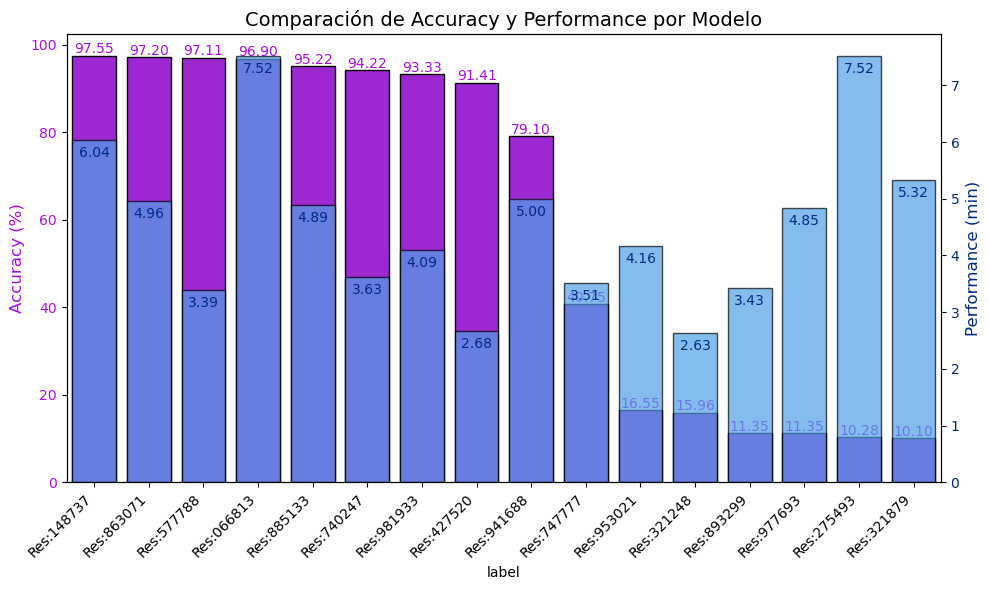

In [76]:
graficar_accuracy_vs_performance(df_final_hiper)

**Observación:** este gráfico resultante me muestra que el learning rate = 0.01 tiene el peor accuracy, cualquiera sea sus otros hiperparámetros, también que con batch más pequeños se demora mucho más. Un learning rate alto puede hacer que el modelo salte entre mínimos locales o se mueva demasiado rápido en la superficie de error, sin llegar a converger adecuadamente. 

Los batches pequeños hacen que la red actualice los pesos más seguido, pero con mucho más ruido (o sea, las actualizaciones no son tan precisas). Esto puede ser que necesitaría hacer más iteraciones para llegar a la misma precisión que con batches más grandes. Además, cada batch pequeño tiene un poco más de trabajo extra en cada cálculo, así que en total puede tomar más tiempo entrenar el modelo. 